# Choice under risk and ambiguity task

Levy, I., Snell, J., Nelson, A. J., Rustichini, A., & Glimcher, P. W. (2010). Neural Representation of Subjective Value Under Risk and Ambiguity. *Journal of Neurophysiology, 103*(2), 1036-1047.

<center>
    <figure>
        <img src="./images/cra-thumbnail.png"
             alt="Overview of the choice under risk and ambiguity task."
             width="500px">
        <figcaption>Overview of the choice under risk and ambiguity task.</figcaption>
    </figure>
</center>

## 1. Initializion

### 1) Task: Choice under risk and ambiguity

<center>
    <figure>
        <img src="./images/cra-design.png"
             align="center"
             width="320px">
        <figcaption>Design variables for the choice under risk and ambiguity task.</figcaption>
    </figure>
</center>

- **Design variables**
    - `p_var` ($p_V$): the probability to win the reward of the variable option
        - Fixed to 0.5 for ambiguous trials
    - `a_var` ($A_V$): the level of ambiguity of the variable option
        - Fixed to 0 for risky trials
    - `r_var` ($R_V$): the amount of reward of the variable option
    - `r_fix` ($R_F$): the amount of reward of the fixed option
- **Response variable**:
    - `choice`: `0` (fixed option), `1` (variable option)

In [1]:
from adopy.tasks.cra import TaskCRA

task = TaskCRA()

In [2]:
task.name

'Choice under risk and ambiguity task'

In [3]:
task.designs

['p_var', 'a_var', 'r_var', 'r_fix']

In [4]:
task.responses

['choice']

### 2) Model: Linear model

$$
\begin{aligned}
    U_F &= 0.5 \cdot (R_F) ^\alpha \\
    U_V &= \left[ p_V - \beta \cdot \frac{A_V}{2} \right] \cdot (R_V) ^\alpha \\
    P(V\, over \, F) &= \frac{1}{1 + \exp [\gamma (U_F - U_V)]}
\end{aligned}
$$

- **Model parameters**
    - `alpha` ($\alpha$): risk attitude parameter
    - `beta` ($\beta$): ambiguity attitude parameter
    - `gamma` ($\gamma$): inverse temperature

In [5]:
from adopy.tasks.cra import ModelLinear

model = ModelLinear()

In [6]:
model.name

'Linear model for the CRA task'

In [7]:
model.params

['alpha', 'beta', 'gamma']

### 3) Grid definition

#### Grid for design variables

In [8]:
import numpy as np

# Rewards
r_var = [5, 9.5, 18, 26, 34, 50, 65, 95, 131, 181, 250]
r_fix = [5, 7, 10, 13, 18, 25, 34, 48, 66, 91, 125]

rewards = np.array([
    [rv, rf] for rv in r_var for rf in r_fix if rv > rf
])

# Prob & Ambig (Risky trials)
p_var_risky = [.13, .25, .38]
pa_risky = np.array([[pr, 0] for pr in p_var_risky])

# Prob & Ambig (Ambiguous trials)
a_var_ambig = [.25, .5, .75]
pa_ambig = np.array([[0.5, am] for am in a_var_ambig])

# Prob & Ambig
pr_am = np.vstack([pa_risky, pa_ambig])

grid_design = {('p_var', 'a_var'): pr_am, ('r_var', 'r_fix'): rewards}

#### Grid for model parameters

In [9]:
grid_param = {
    'alpha': np.linspace(0, 3, 11)[1:],
    'beta': np.linspace(-3, 3, 11),
    'gamma': np.linspace(0, 5, 11)[1:]
}

#### Grid for response variables

In [10]:
grid_response = {
    'choice': [0, 1]
}

### 4) Engine initialization

In [11]:
from adopy import Engine

engine = Engine(task, model, grid_design, grid_param, grid_response)

## 2. Design comparison

1. **ADO design**
2. **Fixed design**, used by Levy et al. (2010)
3. **Random design**

<center>
    <figure>
        <img src="./images/cra-design-fixed.png" width="500px">
        <figcaption>Fixed design - design pairs used by Levy et al. (2010).</figcaption>
    </figure>
</center>

In [12]:
N_TRIAL = 60

### Functions

#### Simulate a response

In [13]:
# True parameter values to simulate responses
PARAM_TRUE = {'alpha': 0.67, 'beta': 0.66, 'gamma': 1.5}

In [14]:
from scipy.stats import bernoulli

def get_simulated_response(design):
    # Calculate the probability to choose a variable option
    p_var, a_var, r_var, r_fix = (
        design['p_var'], design['a_var'], design['r_var'], design['r_fix']
    )
    alpha, beta, gamma = PARAM_TRUE['alpha'], PARAM_TRUE['beta'], PARAM_TRUE['gamma']
    
    u_fix = 0.5 * np.power(r_fix, alpha)
    u_var = (p_var - beta * a_var / 2) * np.power(r_var, alpha)
    
    p_obs = 1 / (1 + np.exp(-gamma * (u_var - u_fix)))

    # Randomly sample a binary choice response from Bernoulli distribution
    return bernoulli.rvs(p_obs)

#### Generate design pairs for the fixed design (Levy et al., 2010)

In [15]:
import pandas as pd

def generate_fixed_designs():
    """Generate design pairs used by Levy et al. (2010)"""
    # Prob & Ambig
    pa_risky = [(.5, a_var) for a_var in [.13, .25, .38]]  # for risky conditions
    pa_ambig = [(p_var, .0) for p_var in [.25, .50, .75]]  # for ambiguous conditions
    pa_var = pa_risky + pa_ambig
    
    # Rewards
    rewards = [(r_var, r_fix) for r_var in [5, 9.5, 18, 34, 65]
                              for r_fix in [5]]

    # Make unique design pairs in a 2d matrix
    designs = [[p_var, a_var, r_var, r_fix] for (p_var, a_var) in pa_var
                                            for (r_var, r_fix) in rewards]

    designs = designs + designs  # Double the design pairs
    np.random.shuffle(designs)  # Shuffle the pairs

    return pd.DataFrame(designs, columns=['p_var', 'a_var', 'r_var', 'r_fix'])

In [16]:
designs_fixed = generate_fixed_designs()
designs_fixed.head()

,p_var,a_var,r_var,r_fix
0,0.5,0.25,18.0,5
1,0.5,0.13,9.5,5
2,0.5,0.25,9.5,5
3,0.5,0.25,65.0,5
4,0.5,0.00,5.0,5


### Simulation

In [17]:
# Make an empty DataFrame to store data
df_simul = pd.DataFrame(
    None, columns=['design_type', 'trial',
                   'mean_alpha', 'mean_beta', 'mean_gamma',
                   'sd_alpha', 'sd_beta', 'sd_gamma'])

# Run simulations for three designs
for design_type in ['optimal', 'staircase', 'random']:
    # Reset the engine as an initial state
    engine.reset()
    
    for i in range(N_TRIAL):
        # Design selection / optimization
        if design_type == 'optimal':
            design = engine.get_design('optimal')
        elif design_type == 'staircase':
            design = designs_fixed.iloc[i, :]
        else:  # design_type == 'random'
            design = engine.get_design('random')
        
        # Experiment
        response = get_simulated_response(design)
        
        # Bayesian updating
        engine.update(design, response)

        # Save the information for updated posteriors
        df_simul = df_simul.append({
            'design_type': design_type,
            'trial': i + 1,
            'mean_alpha': engine.post_mean[0],
            'mean_beta': engine.post_mean[1],
            'mean_gamma': engine.post_mean[2],
            'sd_alpha': engine.post_sd[0],
            'sd_beta': engine.post_sd[1],
            'sd_gamma': engine.post_sd[2],
        }, ignore_index=True)

### Results

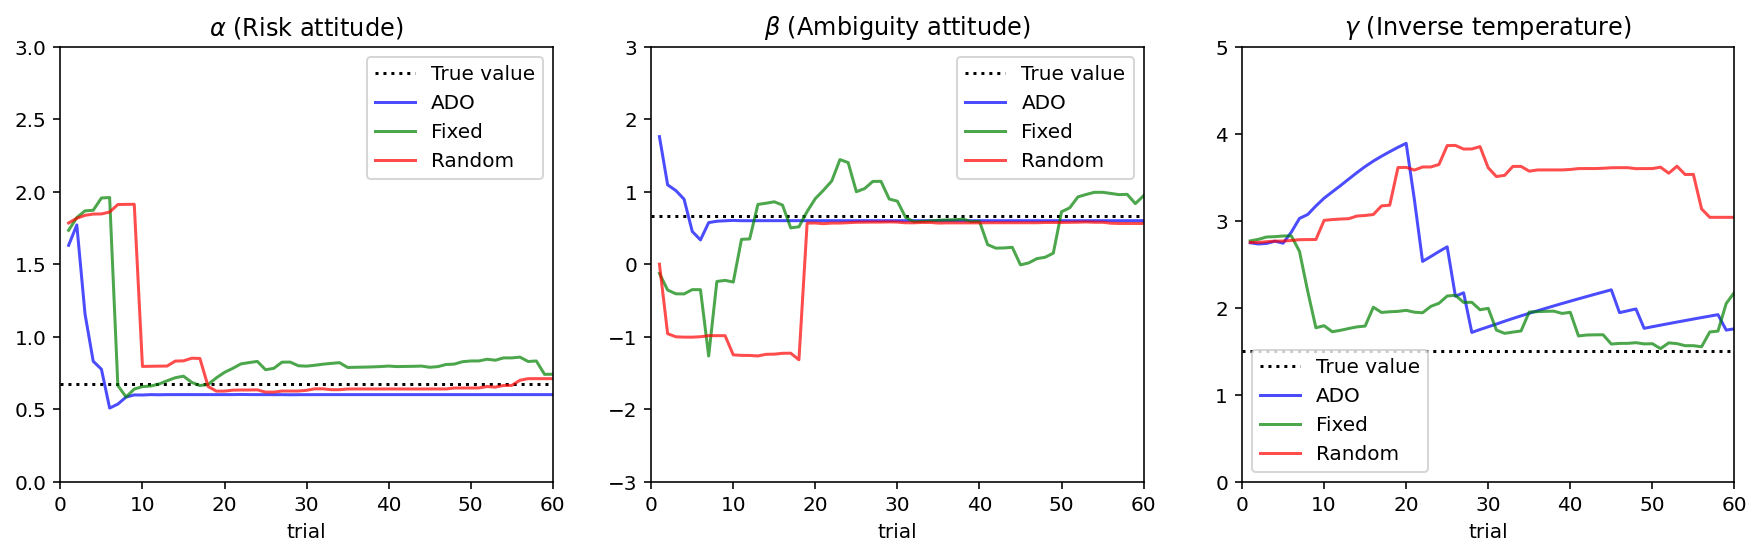

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 3, figsize = [15, 4])

# Draw black dotted lines for true parameters
for i, param in enumerate(['alpha', 'beta', 'gamma']):
    ax[i].axhline(PARAM_TRUE[param], color='black', linestyle=':')

for i, design_type in enumerate(['optimal', 'staircase', 'random']):
    df_cond = df_simul.loc[df_simul['design_type'] == design_type]
    line_color = ['blue', 'green', 'red'][i]
    ax = df_cond.plot(x='trial', y=['mean_alpha', 'mean_beta', 'mean_gamma'], ax=ax,
                      subplots=True, figsize=(15, 4), legend=False, color = line_color, alpha = 0.7)

# Set titles and limits on y axes.
ax[0].set_title('$\\alpha$ (Risk attitude)');        ax[0].set_ylim(0, 3)
ax[1].set_title('$\\beta$ (Ambiguity attitude)');    ax[1].set_ylim(-3, 3)
ax[2].set_title('$\\gamma$ (Inverse temperature)');  ax[2].set_ylim(0, 5)

ax[0].legend(['True value', 'ADO', 'Fixed', 'Random'])
ax[1].legend(['True value', 'ADO', 'Fixed', 'Random'])
ax[2].legend(['True value', 'ADO', 'Fixed', 'Random'])

plt.show()

## References

Levy, I., Snell, J., Nelson, A. J., Rustichini, A., & Glimcher, P. W. (2010). Neural Representation of Subjective Value Under Risk and Ambiguity. Journal of Neurophysiology, 103 (2), 1036-1047.